In [1]:
import numpy as np
import pandas as pd
import pickle
import warnings
import time
import re
import gspread
from oauth2client.service_account import ServiceAccountCredentials

#Graphs
import matplotlib.pyplot as plt
import seaborn as sns

#Sklearn tools
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor 
from sklearn import preprocessing 
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

#pandas show all columns
pd.set_option('display.max_columns', None)
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# define the scope
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']

# add credentials to the account
creds = ServiceAccountCredentials.from_json_keyfile_name('useless-machine-learning-a9027a9eb367.json', scope)

# authorize the clientsheet 
gc = gspread.authorize(creds)

#Pull data from spreadsheet and conver to DataFrame
spreadsheet_key = '1SQpPGP0RYHR4KcOz4XoPFe5y4Mue9D6ilXaAld2dNrI'
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet("LCS Player Data")
bp_vals = worksheet.get_all_values()

bp = pd.DataFrame(bp_vals[1:], columns=bp_vals[0])

In [3]:
spring_2020 = bp[(bp['Split'] == 'Spring') & (bp['Year'] == '2020')].reset_index(drop = True)
summer_2020 = bp[(bp['Split'] == 'Summer') & (bp['Year'] == '2020')].reset_index(drop = True)
spring_2021 = bp[(bp['Split'] == 'Spring') & (bp['Year'] == '2021')].reset_index(drop = True)
summer_2021 = bp[(bp['Split'] == 'Summer') & (bp['Year'] == '2021')].reset_index(drop = True)

In [4]:
lcs_spring_2020 = pd.read_csv('LCS 2020 Spring - Player Stats - OraclesElixir.csv')
lcs_summer_2020 = pd.read_csv('LCS 2020 Summer - Player Stats - OraclesElixir.csv')
lcs_spring_2021 = pd.read_csv('LCS 2021 Spring - Player Stats - OraclesElixir.csv')
lcs_summer_2021 = pd.read_csv('LCS 2021 Summer - Player Stats - OraclesElixir.csv')

In [5]:
full_spring_2020 = spring_2020.merge(lcs_spring_2020, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_summer_2020 = summer_2020.merge(lcs_summer_2020, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_spring_2021 = spring_2021.merge(lcs_spring_2021, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])
full_summer_2021 = summer_2021.merge(lcs_summer_2021, left_on= ['Name', 'Position'], right_on= ['Player', 'Pos'])

In [6]:
total = pd.concat([full_spring_2021, full_summer_2021, full_spring_2020, full_summer_2020], ignore_index=True)

In [7]:
total = total[['Name', 'Split', 'Year', 'Position', 'Rank', 'Player', 'GP', 'W%', 
                  'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
                  'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype(str)

total['W%'] = total['W%'].str.replace('%', '').astype('float')
total['KS%'] = total['KS%'].str.replace('%', '').astype('float')
total['KP'] = total['KP'].str.replace('%', '').astype('float')
total['DTH%'] = total['DTH%'].str.replace('%', '').astype('float')
total['FB%'] = total['FB%'].str.replace('%', '').astype('float')
total['CS%P15'] = total['CS%P15'].str.replace('%', '').astype('float')
total['DMG%'] = total['DMG%'].str.replace('%', '').astype('float')
total['GOLD%'] = total['GOLD%'].str.replace('%', '').astype('float')

total[['Rank', 'GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
      'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']] = total[['Rank', 'GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype('float')

In [8]:
total['K'] = total['K']/total['GP']
total['A'] = total['A']/total['GP']
total['D'] = total['D']/total['GP']
total.drop('GP', axis = 1, inplace = True)

In [9]:
jg = total[total['Position'] == 'Jungle']

features = ['W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']

### Correlation Matrix

In [10]:
regressor = RandomForestRegressor(n_estimators=500)

x_jg = jg[features].to_numpy()
y_jg = jg[['Rank']].to_numpy()
y_jg = y_jg.reshape(y_jg.shape[0], )
regressor.fit(x_jg, y_jg)
jg_ind = np.argsort(regressor.feature_importances_)[::-1]
for i in jg_ind:
    print(f"{features[i]}: {regressor.feature_importances_[i]:.4f}")

K: 0.6132
KDA: 0.0993
DMG%: 0.0483
DPM: 0.0398
GOLD%: 0.0336
GD10: 0.0323
FB%: 0.0254
KP: 0.0228
WCPM: 0.0198
A: 0.0115
XPD10: 0.0073
D: 0.0072
W%: 0.0070
KS%: 0.0069
DTH%: 0.0055
CS%P15: 0.0052
CSD10: 0.0044
WPM: 0.0040
EGPM: 0.0039
CSPM: 0.0025


<AxesSubplot:>

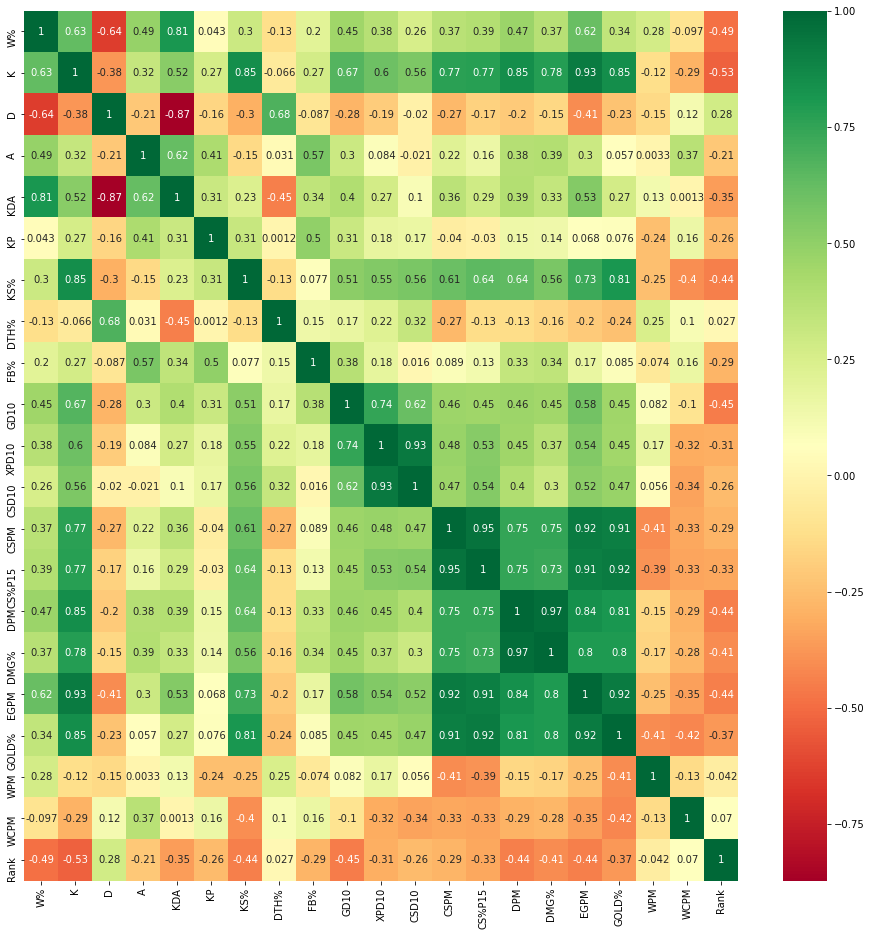

In [11]:
jg_corr = jg[features + ["Rank"]]

fig = plt.figure(figsize=(16, 16))
fig.set_facecolor('white')
sns.heatmap(jg_corr.corr(), annot=True, cmap="RdYlGn")

Remove KS%, EGPM, GOLD%, DTH%, CSPM, CS%P15, DPM, CSD10, DMG%


In [51]:
jg_features = ['W%', 'K', 'D', 'A', 'KDA', 'KP', 'FB%', 'XPD10', 'WCPM']

In [52]:
means = []
for i in jg_features: 
    means.append(jg[i].mean())

for j, k in enumerate(jg_features): 
    jg.loc[:,k] = jg[k].apply(lambda x: (x - means[j])/means[j])

### Normalizing and train test splitting data

In [53]:
X_jg = jg[jg_features].values
y_jg = jg[['Rank']].values

PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X_jg)
 
# Generating the standardized values of X
X_jg = PredictorScalerFit.transform(X_jg)
 
# Split the data into training and testing set
X_train_jg, X_test_jg, y_train_jg, y_test_jg = train_test_split(X_jg, y_jg, test_size=0.3, random_state=42)

### Linear Regression Results

In [54]:
lin_regressor = LinearRegression()  
lin_regressor.fit(X_train_jg, y_train_jg)
lin_pred = lin_regressor.predict(X_test_jg)
df1 = pd.DataFrame({'Actual': y_test_jg.flatten(), 'Predicted': lin_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_jg, lin_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_jg, lin_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_jg, lin_pred)))

Mean Absolute Error: 0.520151325609926
Mean Squared Error: 0.4063323080508016
Root Mean Squared Error: 0.6374420036762573


### Decision Tree Results

In [55]:
dec_regressor = DecisionTreeRegressor(random_state = 0)
dec_regressor.fit(X_train_jg, y_train_jg)
dec_pred = dec_regressor.predict(X_test_jg)
df2 = pd.DataFrame({'Actual': y_test_jg.flatten(), 'Predicted': dec_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_jg, dec_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_jg, dec_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_jg, dec_pred)))

Mean Absolute Error: 0.4049197372748082
Mean Squared Error: 0.3046090417452128
Root Mean Squared Error: 0.5519139803857235


### KNN Results

In [56]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=2)
knn_regressor.fit(X_train_jg, y_train_jg)
knn_pred = knn_regressor.predict(X_test_jg)
df3 = pd.DataFrame({'Actual': y_test_jg.flatten(), 'Predicted': knn_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_jg, knn_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_jg, knn_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_jg, knn_pred)))

Mean Absolute Error: 0.5058139534883721
Mean Squared Error: 0.5261627906976745
Root Mean Squared Error: 0.7253707953162124


### SVR Results

In [57]:
svr_regressor = SVR(kernel = 'rbf')
svr_regressor.fit(X_train_jg, y_train_jg)
svr_pred = svr_regressor.predict(X_test_jg)
df4 = pd.DataFrame({'Actual': y_test_jg.flatten(), 'Predicted': svr_pred.flatten()})
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_jg, svr_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_jg, svr_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_jg, svr_pred)))

Mean Absolute Error: 0.37609526819045036
Mean Squared Error: 0.34031041323646305
Root Mean Squared Error: 0.5833613059129505


### ANN Results

In [58]:
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()
 
# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units = 5, input_dim = len(jg_features), kernel_initializer='normal', activation='relu'))
 
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'tanh'))
 
# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer = 'normal'))
 
# Compiling the model
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
# Fitting the ANN to the Training set
model.fit(X_train_jg, y_train_jg, batch_size = 10, epochs = 50, verbose=1)

Epoch 1/50
40/40 [==============================] - 0s 1ms/step - loss: 4.5365
Epoch 2/50
40/40 [==============================] - 0s 900us/step - loss: 4.0909
Epoch 3/50
40/40 [==============================] - 0s 924us/step - loss: 3.2075
Epoch 4/50
40/40 [==============================] - 0s 923us/step - loss: 2.1376
Epoch 5/50
40/40 [==============================] - 0s 828us/step - loss: 1.3467
Epoch 6/50
40/40 [==============================] - 0s 835us/step - loss: 0.9100
Epoch 7/50
40/40 [==============================] - 0s 882us/step - loss: 0.7038
Epoch 8/50
40/40 [==============================] - 0s 870us/step - loss: 0.6039
Epoch 9/50
40/40 [==============================] - 0s 848us/step - loss: 0.5495
Epoch 10/50
40/40 [==============================] - 0s 856us/step - loss: 0.5092
Epoch 11/50
40/40 [==============================] - 0s 885us/step - loss: 0.4765
Epoch 12/50
40/40 [==============================] - 0s 841us/step - loss: 0.4488
Epoch 13/50
40/40 [========

In [59]:
def FunctionFindBestParams(X_train, y_train, X_test, y_test):
    
    # Defining the list of hyper parameters to try
    batch_size_list = [5, 10, 15, 20]
    epoch_list = [5, 10, 50, 100]
    
    import pandas as pd
    SearchResultsData = pd.DataFrame(columns = ['TrialNumber', 'Parameters', 'Accuracy'])
    
    # initializing the trials
    TrialNumber = 0
    for batch_size_trial in batch_size_list:
        for epochs_trial in epoch_list:
            TrialNumber += 1
            # create ANN model
            model = Sequential()
            # Defining the first layer of the model
            model.add(Dense(units = 5, input_dim = X_train.shape[1], kernel_initializer = 'normal', activation = 'relu'))
 
            # Defining the Second layer of the model
            model.add(Dense(units = 5, kernel_initializer = 'normal', activation = 'relu'))
 
            # The output neuron is a single fully connected node 
            # Since we will be predicting a single number
            model.add(Dense(1, kernel_initializer = 'normal'))
 
            # Compiling the model
            model.compile(loss = 'mean_squared_error', optimizer = 'adam')
 
            # Fitting the ANN to the Training set
            model.fit(X_train, y_train ,batch_size = batch_size_trial, epochs = epochs_trial, verbose=0)
 
            MAPE = np.mean(100 * (np.abs(y_test - model.predict(X_test))/y_test))
            
            # printing the results of the current iteration
            print(TrialNumber, 'Parameters:','batch_size:', batch_size_trial,'-', 'epochs:', epochs_trial, 'Accuracy:', 100-MAPE)
            
            SearchResultsData = SearchResultsData.append(pd.DataFrame(data = [[TrialNumber, str(batch_size_trial) + '-' + str(epochs_trial), 100-MAPE]],
                                                                    columns = ['TrialNumber', 'Parameters', 'Accuracy'] ))
    return(SearchResultsData)
 

In [60]:
ResultsData = FunctionFindBestParams(X_train_jg, y_train_jg, X_test_jg, y_test_jg)

1 Parameters: batch_size: 5 - epochs: 5 Accuracy: 61.076969116233116
2 Parameters: batch_size: 5 - epochs: 10 Accuracy: 70.76377377722615
3 Parameters: batch_size: 5 - epochs: 50 Accuracy: 74.5039741891299
4 Parameters: batch_size: 5 - epochs: 100 Accuracy: 74.22398793142895
5 Parameters: batch_size: 10 - epochs: 5 Accuracy: 58.581919430993324
6 Parameters: batch_size: 10 - epochs: 10 Accuracy: 65.92146587926288
7 Parameters: batch_size: 10 - epochs: 50 Accuracy: 74.07975530670595
8 Parameters: batch_size: 10 - epochs: 100 Accuracy: 74.41906580167223
9 Parameters: batch_size: 15 - epochs: 5 Accuracy: 32.790751033282106
10 Parameters: batch_size: 15 - epochs: 10 Accuracy: 63.47270202498103
11 Parameters: batch_size: 15 - epochs: 50 Accuracy: 69.2520838721778
12 Parameters: batch_size: 15 - epochs: 100 Accuracy: 74.15597341781438
13 Parameters: batch_size: 20 - epochs: 5 Accuracy: 13.655214349544323
14 Parameters: batch_size: 20 - epochs: 10 Accuracy: 54.15349652369817
15 Parameters: bat

<AxesSubplot:xlabel='Parameters'>

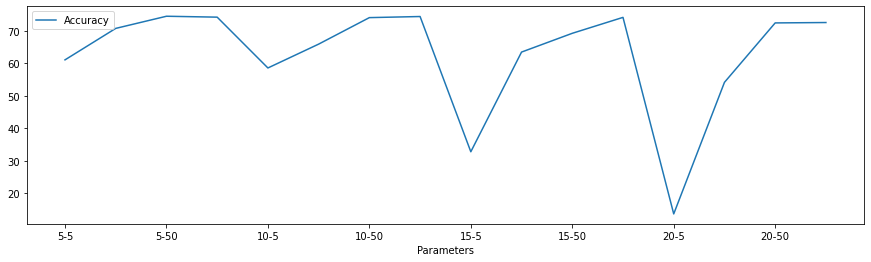

In [61]:
%matplotlib inline
ResultsData.plot(x = 'Parameters', y = 'Accuracy', figsize=(15,4), kind = 'line')

Batch size 10 and epochs = 100 results in the best accuracy

In [62]:
# Fitting the ANN to the Training set
model.fit(X_train_jg, y_train_jg ,batch_size = 5, epochs = 50, verbose=0)

# Generating Predictions on testing data
ann_pred = model.predict(X_test_jg)

# Scaling the test data back to original scale
Test_Data = PredictorScalerFit.inverse_transform(X_test_jg)

TestingData = pd.DataFrame(data = Test_Data, columns = jg_features)
TestingData['Rank'] = y_test_jg
TestingData['Predicted Rank'] = ann_pred

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_jg, ann_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_jg, ann_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_jg, ann_pred)))

Mean Absolute Error: 0.43772390692733054
Mean Squared Error: 0.319810276547995
Root Mean Squared Error: 0.5655177066617764


### Compare Model Predictions

In [63]:
lcs_spring_2022 = pd.read_csv('LCS 2022 Spring - Player Stats - OraclesElixir.csv')

jg_lcs_2022 = lcs_spring_2022[(lcs_spring_2022['Pos'] == 'Jungle') & (lcs_spring_2022['GP'] >= 12)]

jg_lcs_2022 = jg_lcs_2022[['Player', 'Pos', 'GP', 'W%', 'CTR%', 'K', 'D', 'A', 'KDA', 'KP',
       'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 'CSPM', 'CS%P15', 'DPM',
       'DMG%', 'D%P15', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype(str)

jg_lcs_2022['W%'] = jg_lcs_2022['W%'].str.replace('%', '').astype('float')
jg_lcs_2022['KS%'] = jg_lcs_2022['KS%'].str.replace('%', '').astype('float')
jg_lcs_2022['KP'] = jg_lcs_2022['KP'].str.replace('%', '').astype('float')
jg_lcs_2022['DTH%'] = jg_lcs_2022['DTH%'].str.replace('%', '').astype('float')
jg_lcs_2022['FB%'] = jg_lcs_2022['FB%'].str.replace('%', '').astype('float')
jg_lcs_2022['CS%P15'] = jg_lcs_2022['CS%P15'].str.replace('%', '').astype('float')
jg_lcs_2022['DMG%'] = jg_lcs_2022['DMG%'].str.replace('%', '').astype('float')
jg_lcs_2022['GOLD%'] = jg_lcs_2022['GOLD%'].str.replace('%', '').astype('float')

jg_lcs_2022[['GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
      'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']] = jg_lcs_2022[['GP', 'W%', 'K', 'D', 'A', 'KDA', 'KP', 'KS%', 'DTH%', 'FB%', 'GD10', 'XPD10', 'CSD10', 
            'CSPM', 'CS%P15', 'DPM', 'DMG%', 'EGPM', 'GOLD%', 'WPM', 'WCPM']].astype('float')

jg_lcs_2022['K'] = jg_lcs_2022['K']/jg_lcs_2022['GP']
jg_lcs_2022['A'] = jg_lcs_2022['A']/jg_lcs_2022['GP']
jg_lcs_2022['D'] = jg_lcs_2022['D']/jg_lcs_2022['GP']
jg_lcs_2022.drop('GP', axis = 1, inplace = True)

means = []
for i in jg_features: 
    means.append(jg_lcs_2022[i].mean())

for j, k in enumerate(jg_features): 
    jg_lcs_2022.loc[:,k] = jg_lcs_2022[k].apply(lambda x: (x - means[j])/means[j])

X_jg_lcs_sp2022 = jg_lcs_2022[jg_features].values
jg_lcs_sp2022_names = jg_lcs_2022['Player']

PredictorScaler=StandardScaler()
 
# Storing the fit object for later reference
PredictorScalerFit = PredictorScaler.fit(X_jg_lcs_sp2022)
 
# Generating the standardized values of X
X_jg_lcs_sp2022 = PredictorScalerFit.transform(X_jg_lcs_sp2022)

jg_lin = lin_regressor.predict(X_jg_lcs_sp2022)
jg_dec = dec_regressor.predict(X_jg_lcs_sp2022)
jg_knn = knn_regressor.predict(X_jg_lcs_sp2022)
jg_svr = svr_regressor.predict(X_jg_lcs_sp2022)
jg_ann = model.predict(X_jg_lcs_sp2022)

In [64]:
jg_lin = pd.DataFrame(jg_lin)
jg_lin.rename(columns={0:'Rank'}, inplace= True)
jg_names = jg_lcs_2022[['Player']].reset_index(drop = True)
jg_final_lin = pd.concat([jg_names, jg_lin], axis=1)
jg_final_lin.sort_values(by='Rank', ascending=True, inplace=True)
jg_final_lin.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(jg_final_lin)):
    jg_final_lin.loc[i, 'Rank'] = initial
    initial += 1

jg_final_lin

,Player,Rank
0,Santorin,1.0
1,Closer,2.0
2,Blaber,3.0
3,Inspired,4.0
4,Pridestalker,5.0
5,Josedeodo,6.0
6,River,7.0
7,Spica,8.0
8,Contractz,9.0
9,Xerxe,10.0


In [65]:
jg_dec = pd.DataFrame(jg_dec)
jg_dec.rename(columns={0:'Rank'}, inplace= True)
jg_names = jg_lcs_2022[['Player']].reset_index(drop = True)
jg_final_dec = pd.concat([jg_names, jg_dec], axis=1)
jg_final_dec.sort_values(by='Rank', ascending=True, inplace=True)
jg_final_dec.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(jg_final_dec)):
    jg_final_dec.loc[i, 'Rank'] = initial
    initial += 1

jg_final_dec

,Player,Rank
0,Santorin,1.0
1,Closer,2.0
2,River,3.0
3,Josedeodo,4.0
4,Pridestalker,5.0
5,Spica,6.0
6,Contractz,7.0
7,Xerxe,8.0
8,Blaber,9.0
9,Inspired,10.0


In [66]:
jg_knn = pd.DataFrame(jg_knn)
jg_knn.rename(columns={0:'Rank'}, inplace= True)
jg_names = jg_lcs_2022[['Player']].reset_index(drop = True)
jg_final_knn = pd.concat([jg_names, jg_knn], axis=1)
jg_final_knn.sort_values(by='Rank', ascending=True, inplace=True)
jg_final_knn.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(jg_final_knn)):
    jg_final_knn.loc[i, 'Rank'] = initial
    initial += 1

jg_final_knn

,Player,Rank
0,Closer,1.0
1,Santorin,2.0
2,Contractz,3.0
3,River,4.0
4,Xerxe,5.0
5,Blaber,6.0
6,Inspired,7.0
7,Josedeodo,8.0
8,Pridestalker,9.0
9,Spica,10.0


In [67]:
jg_svr = pd.DataFrame(jg_svr)
jg_svr.rename(columns={0:'Rank'}, inplace= True)
jg_names = jg_lcs_2022[['Player']].reset_index(drop = True)
jg_final_svr = pd.concat([jg_names, jg_svr], axis=1)
jg_final_svr.sort_values(by='Rank', ascending=True, inplace=True)
jg_final_svr.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(jg_final_svr)):
    jg_final_svr.loc[i, 'Rank'] = initial
    initial += 1

jg_final_svr

,Player,Rank
0,Blaber,1.0
1,Inspired,2.0
2,Closer,3.0
3,River,4.0
4,Santorin,5.0
5,Pridestalker,6.0
6,Spica,7.0
7,Josedeodo,8.0
8,Contractz,9.0
9,Xerxe,10.0


In [68]:
jg_ann = pd.DataFrame(jg_ann)
jg_ann.rename(columns={0:'Rank'}, inplace= True)
jg_names = jg_lcs_2022[['Player']].reset_index(drop = True)
jg_final_ann = pd.concat([jg_names, jg_ann], axis=1)
jg_final_ann.sort_values(by='Rank', ascending=True, inplace=True)
jg_final_ann.reset_index(drop=True, inplace = True)

initial = 1
for i in range(0, len(jg_final_ann)):
    jg_final_ann.loc[i, 'Rank'] = initial
    initial += 1

jg_final_ann

,Player,Rank
0,Blaber,1.0
1,Santorin,2.0
2,Josedeodo,3.0
3,Closer,4.0
4,Inspired,5.0
5,River,6.0
6,Pridestalker,7.0
7,Spica,8.0
8,Contractz,9.0
9,Xerxe,10.0


All models outside of svr, dec, and knn seem reasonable

### Combined Results Ensemble Averaging

In [69]:
all_pred = (1/2*ann_pred.reshape(-1,1) + 1/2*lin_pred.reshape(-1,1))

In [70]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test_jg, all_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test_jg, all_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test_jg, all_pred)))

Mean Absolute Error: 0.4769341879372781
Mean Squared Error: 0.34845325677279365
Root Mean Squared Error: 0.590299294233691


### Predicting for the Spring 2022 LCS Players

In [72]:
final = pd.merge(jg_final_ann, jg_final_lin, on = 'Player')
final['Final Rank'] = final.iloc[:].sum(axis = 1)/2
final.sort_values(by = 'Final Rank', ascending = True, inplace = True)
final

,Player,Rank_x,Rank_y,Final Rank
1,Santorin,2.0,1.0,1.5
0,Blaber,1.0,3.0,2.0
3,Closer,4.0,2.0,3.0
2,Josedeodo,3.0,6.0,4.5
4,Inspired,5.0,4.0,4.5
6,Pridestalker,7.0,5.0,6.0
5,River,6.0,7.0,6.5
7,Spica,8.0,8.0,8.0
8,Contractz,9.0,9.0,9.0
9,Xerxe,10.0,10.0,10.0
